In [1]:
import os
import sys
import xarray as xr
import numpy as np
from numpy import unravel_index
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyArrowPatch

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
grey_color = plt.cm.Greys(np.linspace(0.2, 0.8, 10))

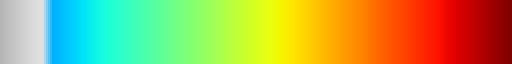

In [4]:
colors1 = plt.cm.Greys_r(np.linspace(0.6, 0.8, 5))
colors2 = plt.cm.jet(np.linspace(0.3, 1, 45))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mixedmap = LinearSegmentedColormap.from_list('my_colormap', colors)
mixedmap

In [5]:
# # set fonts configuration - Arial
# matplotlib.rcParams['font.family'] = "Open Sans"
# matplotlib.rcParams['font.sans-serif'] = "Arial"

In [6]:
stats_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/cape_subsat_hist/')

In [7]:
data= xr.open_dataset('/scratch/wmtsai/temp_mcs/output_stats/era5_0.25deg_BL_2Dhistogram.wbwl.landsea.2001-2010.nc')

samples_clim_ocean = data.sel(surface_type='ocean').samples
samples_clim_land = data.sel(surface_type='land').samples

In [8]:
%%time
year_list = np.arange(2001,2021)

for n,year in enumerate(year_list):
    
    data = xr.open_dataset(stats_dir / 'hist2d_cape_subsat_dtype.{}.ocean.FNL.alltracks.nc'.format(year))
    if n == 0:
        samples_all_ocean = data.samples
    else:
        samples_all_ocean = samples_all_ocean + data.samples

CPU times: user 203 ms, sys: 258 ms, total: 461 ms
Wall time: 470 ms


In [ ]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(6,4.5))

for p,(ax,phase,label) in enumerate(zip([ax1,ax2,ax3,ax4,ax5,ax6]
                                        ,samples_all_ocean.phase.values,
                                        ['(a)','(b)','(c)','(d)','(e)','(f)'])):
    
    tmp = samples_all_ocean.sel(duration_type=['SL','ML','LL','UL','UUL'], area_type='mcs', phase=phase).sum('duration_type')
    tmp = tmp.where(tmp > 100)
    cp = ax.pcolormesh(tmp.bins_subsat, tmp.bins_cape, tmp/tmp.sum(), cmap=mixedmap, vmin=0, vmax=0.015,
                    zorder=1)

    if phase == 'End':
        cbaxes = fig.add_axes([0.99, 0.3, 0.01, 0.4])              
        cbar = plt.colorbar(cp, cax=cbaxes, shrink=0.7)
        cbar.set_label('Probability',fontsize=9)
        
    ax.set_title('{} {}'.format(label,phase),x=0.05,y=0.85,fontsize=9,color='k',loc='left')
    
    # add buoyancy reference 
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+2, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+4, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+6, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-4, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-6, color='grey', ls='--',lw=0.5)
        
    # add MCS joint PDF mode 
    (idx,idy) = unravel_index(tmp.argmax(), tmp.shape)
    ax.plot(tmp.bins_subsat[idy].values, tmp.bins_cape[idx].values, '*', ms=5, color='grey'
            ,markeredgecolor='k')
    
    # add climatology joint PDF as reference
    hist2d_clim_ocean = (samples_clim_ocean/samples_clim_ocean.sum())
    hist2d_clim_ocean = hist2d_clim_ocean.where(hist2d_clim_ocean > 0)
    #cf = ax.contour(hist2d_clim_ocean.BL_subsat_bins, hist2d_clim_ocean.BL_cape_bins, hist2d_clim_ocean
    #                , levels=np.arange(0.001,0.025,0.005), colors=['violet'],linewidths=1, zorder=3)
    #ax.clabel(cf, cf.levels, inline=False, fontsize=7)
    # reference lines for the mode of climatology
    (idx,idy) = unravel_index(samples_clim_ocean.argmax(), samples_clim_ocean.shape)
    ax.vlines(x=samples_clim_ocean.BL_subsat_bins[idy], ymin=-4, ymax=10, color='violet', ls='--', lw=1)
    ax.hlines(y=samples_clim_ocean.BL_cape_bins[idx], xmin=-2, xmax=14, color='violet', ls='--',lw=1)
    
    if p == 3 or p == 4 or p == 5:
        ax.set_xlabel('B$_{L,subsat}$ (K)',fontsize=10, labelpad=0)
    ax.set_xticks([-2,0,2,4,6,8,10,12])
    if p == 0 or p == 3:
        ax.set_ylabel('B$_{L,cape}$ (K)',fontsize=10, labelpad=0)
    ax.set_yticks([-4,-2,0,2,4,6,8,10])
    ax.tick_params(labelsize=9)
    ax.tick_params('both', length=2, width=1, which='major')
    
    # set x-y domain 
    ax.set_ylim([-4,5])
    ax.set_xlim([-2,10])

plt.suptitle('Tropical MCSs, ocean, MCS grids, all durations',fontsize=10.5, fontweight='bold',y=0.97);
plt.tight_layout(h_pad=0.01,w_pad=0.01)

fig.savefig('/scratch/wmtsai/temp_mcs/fig/BL2Dhist_jointPDF_phase_ocean.png',dpi=300,
        bbox_inches='tight',transparent=False)

In [ ]:
# plot trajectories of mean values for different MCS durations

mean_array = np.zeros((4,5,6,2)) # mode (area_type, duration_type, mcs_phase, cape/subsat)
mode_array = np.copy(mean_array) # mean
bins_cape = samples_all_ocean.bins_cape
bins_subsat = samples_all_ocean.bins_subsat
tracknum = np.zeros(5)

for a, atype in enumerate(samples_all_ocean.area_type.values):
    for n, dtype in enumerate(['SL','ML','LL','UL','UUL']):
        
        tracknum[n] = samples_all_ocean.sel(duration_type=dtype, area_type='amean', phase='CCS').sum()

        for p,phase in enumerate(samples_all_ocean.phase.values):
            
            # mean
            tmp = samples_all_ocean.sel(duration_type=dtype, area_type=atype, phase=phase)
            cape_mean = np.sum(bins_cape*(tmp.sum('bins_subsat'))/tmp.sum())
            subsat_mean = np.sum(bins_subsat*(tmp.sum('bins_cape'))/tmp.sum())
            mean_array[a,n,p,0] = cape_mean.values
            mean_array[a,n,p,1] = subsat_mean.values
            
            # mode
            (idx,idy) = unravel_index(tmp.argmax(), tmp.shape)
            mode_array[a,n,p,0] = bins_cape[idx]
            mode_array[a,n,p,1] = bins_subsat[idy]
    
# save into xarrat dataset
ds_BLmodes = xr.Dataset(data_vars=dict(cape_mean=(['area_type','duration_type','phase'],mean_array[:,:,:,0]),
                                       subsat_mean=(['area_type','duration_type','phase'],mean_array[:,:,:,1]),
                                       cape_mode=(['area_type','duration_type','phase'],mode_array[:,:,:,0]),
                                       subsat_mode=(['area_type','duration_type','phase'],mode_array[:,:,:,1]),                                       
                                       tracknum=(['duration_type'],tracknum)),
                        coords=dict(area_type=(['area_type'],samples_all_ocean.area_type.values),
                                    duration_type=(['duration_type'],samples_all_ocean.duration_type.values),
                                    phase=(['phase'],samples_all_ocean.phase.values)))

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4.5,4))

ccolors = ['k','limegreen','orange','b','red']

for n, (dtype,ccolor) in enumerate(zip(['SL','ML','LL','UL','UUL'],ccolors)):
    
    cape_mean = ds_BLmodes.sel(duration_type=dtype,area_type='mcs').cape_mean
    subsat_mean = ds_BLmodes.sel(duration_type=dtype,area_type='mcs').subsat_mean

    tracknum = ds_BLmodes.tracknum.sel(duration_type=dtype)
    ax.plot(subsat_mean, cape_mean, color=ccolor, marker='*', ms=8, label=dtype+' ({})'.format(int(tracknum)))
    
    # add phase indicator
    for p,p_str in zip([1,3,5],['I','M','E']):
        ax.text(subsat_mean[p].values-0.05, cape_mean[p].values+0.05, p_str, fontsize=10, color=ccolor)

ax.legend(fontsize=8, loc=3);

# add buoyancy reference 
ax.plot(np.linspace(-2,10,13),np.linspace(-2,10,13)-2, color='k', ls='--',lw=0.5)
ax.plot(np.linspace(-2,10,13),np.linspace(-2,10,13)-3, color='k', ls='--',lw=0.5)
ax.plot(np.linspace(-2,10,13),np.linspace(-2,10,13)-4, color='k', ls='--',lw=0.5)
ax.plot(np.linspace(-2,10,13),np.linspace(-2,10,13)-5, color='k', ls='--',lw=0.5)
ax.plot(np.linspace(-2,10,13),np.linspace(-2,10,13)-6, color='k', ls='--',lw=0.5)

ax.set_ylim([-0.5,1])
ax.set_xlim([2.7,5])
#ax.set_yticks([0.75,1.25,1.75,2.25,2.75])
ax.grid(ls=':',lw=0.5)
ax.set_xlabel('B$_{L,subsat}$ (K)',fontsize=12)
ax.set_ylabel('B$_{L,cape}$ (K)',fontsize=12)

#add climatology mean of CAPE and SUBSAT as reference
#tmp = samples_clim_ocean
#(idx,idy) = unravel_index(samples_clim_ocean.argmax(), samples_clim_ocean.shape)
#ax.vlines(x=samples_clim_ocean.BL_subsat_bins[idy], ymin=-4, ymax=10, color='violet', ls='--', lw=1)
#ax.hlines(y=samples_clim_ocean.BL_cape_bins[idx], xmin=-2, xmax=14, color='violet', ls='--',lw=1)

#ax.plot(samples_clim_ocean.BL_subsat_bins[idy], samples_clim_ocean.BL_cape_bins[idx], '*', ms=10
#        ,color='m', markeredgecolor='k')
#cbar = plt.colorbar(cf,ax=ax,shrink=0.7,pad=0.02)
#cbar.set_label('Probability of B$_{L,climate}$', fontsize=10)

ax.set_title('Trajectory of the means, MCS grids, Ocean \n 2001-2020',fontsize=9.5,fontweight='bold')

#### Same analyses but for MCSs over land

In [9]:
%%time
year_list = np.arange(2001,2021)

for n,year in enumerate(year_list):
    
    data = xr.open_dataset(stats_dir / 'hist2d_cape_subsat_dtype.{}.land.FNL.alltracks.nc'.format(year))
    if n == 0:
        samples_all_land = data.samples
    else:
        samples_all_land = samples_all_land + data.samples

CPU times: user 315 ms, sys: 332 ms, total: 647 ms
Wall time: 647 ms


In [ ]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(6,4.5))

for p,(ax,phase,label) in enumerate(zip([ax1,ax2,ax3,ax4,ax5,ax6]
                                        ,samples_all_land.phase.values,
                                        ['(a)','(b)','(c)','(d)','(e)','(f)'])):
    
    tmp = samples_all_land.sel(duration_type=['SL','ML','LL','UL','UUL'], area_type='mcs', phase=phase).sum('duration_type')
    tmp = tmp.where(tmp > 100)
    cp = ax.pcolormesh(tmp.bins_subsat, tmp.bins_cape, tmp/tmp.sum(), cmap=mixedmap, vmin=0, vmax=0.015,
                    zorder=1)

    if phase == 'End':
        cbaxes = fig.add_axes([0.99, 0.3, 0.01, 0.4])              
        cbar = plt.colorbar(cp, cax=cbaxes, shrink=0.7)
        cbar.set_label('Probability',fontsize=9)
        
    ax.set_title('{} {}'.format(label,phase),x=0.05,y=0.85,fontsize=9,color='k',loc='left')
    
    # add buoyancy reference 
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+2, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+4, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+6, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-4, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-6, color='grey', ls='--',lw=0.5)
        
    # add MCS joint PDF mode 
    (idx,idy) = unravel_index(tmp.argmax(), tmp.shape)
    ax.plot(tmp.bins_subsat[idy].values, tmp.bins_cape[idx].values, '*', ms=5, color='grey'
            ,markeredgecolor='k')
    
    # add climatology joint PDF as reference
    #hist2d_clim_land = (samples_clim_land/samples_clim_land.sum())
    #hist2d_clim_land = hist2d_clim_land.where(hist2d_clim_land > 0)
    #cf = ax.contour(hist2d_clim_land.BL_subsat_bins, hist2d_clim_land.BL_cape_bins, hist2d_clim_land
    #                , levels=np.arange(0.001,0.025,0.005), colors=['violet'],linewidths=1, zorder=3)
    #ax.clabel(cf, cf.levels, inline=False, fontsize=7)
    # reference lines for the mode of climatology
    (idx,idy) = unravel_index(samples_clim_land.argmax(), samples_clim_land.shape)
    ax.vlines(x=samples_clim_land.BL_subsat_bins[idy], ymin=-4, ymax=10, color='violet', ls='--', lw=1)
    ax.hlines(y=samples_clim_land.BL_cape_bins[idx], xmin=-2, xmax=14, color='violet', ls='--',lw=1)
    
    if p == 3 or p == 4 or p == 5:
        ax.set_xlabel('B$_{L,subsat}$ (K)',fontsize=10, labelpad=0)
    ax.set_xticks([-2,0,2,4,6,8,10,12])
    if p == 0 or p == 3:
        ax.set_ylabel('B$_{L,cape}$ (K)',fontsize=10, labelpad=0)
    ax.set_yticks([-4,-2,0,2,4,6,8,10])
    ax.tick_params(labelsize=9)
    ax.tick_params('both', length=2, width=1, which='major')
    
    # set x-y domain 
    ax.set_ylim([-4,5])
    ax.set_xlim([-2,10])

plt.suptitle('Tropical MCSs, land, MCS grids, all durations',fontsize=10.5, fontweight='bold',y=0.97);
plt.tight_layout(h_pad=0.01,w_pad=0.01)

fig.savefig('/scratch/wmtsai/temp_mcs/fig/BL2Dhist_jointPDF_phase_land.png',dpi=300,
        bbox_inches='tight',transparent=False)

#### Trajectory in the CAPE-SUBSAT diagram 

In [ ]:
# plot trajectories of mean values for different MCS durations

mean_array = np.zeros((4,5,6,2)) # mode (area_type, duration_type, mcs_phase, cape/subsat)
mode_array = np.copy(mean_array) # mean
bins_cape = samples_all_land.bins_cape
bins_subsat = samples_all_land.bins_subsat
tracknum = np.zeros(5)

for a, atype in enumerate(samples_all_land.area_type.values):
    for n, dtype in enumerate(['SL','ML','LL','UL','UUL']):
        
        tracknum[n] = samples_all_land.sel(duration_type=dtype, area_type='amean', phase='CCS').sum()

        for p,phase in enumerate(samples_all_land.phase.values):
            
            # mean
            tmp = samples_all_land.sel(duration_type=dtype, area_type=atype, phase=phase)
            cape_mean = np.sum(bins_cape*(tmp.sum('bins_subsat'))/tmp.sum())
            subsat_mean = np.sum(bins_subsat*(tmp.sum('bins_cape'))/tmp.sum())
            mean_array[a,n,p,0] = cape_mean.values
            mean_array[a,n,p,1] = subsat_mean.values
            
            # mode
            (idx,idy) = unravel_index(tmp.argmax(), tmp.shape)
            mode_array[a,n,p,0] = bins_cape[idx]
            mode_array[a,n,p,1] = bins_subsat[idy]
    
# save into xarrat dataset
ds_BLmodes_land = xr.Dataset(data_vars=dict(cape_mean=(['area_type','duration_type','phase'],mean_array[:,:,:,0]),
                                       subsat_mean=(['area_type','duration_type','phase'],mean_array[:,:,:,1]),
                                       cape_mode=(['area_type','duration_type','phase'],mode_array[:,:,:,0]),
                                       subsat_mode=(['area_type','duration_type','phase'],mode_array[:,:,:,1]),                                       
                                       tracknum=(['duration_type'],tracknum)),
                        coords=dict(area_type=(['area_type'],samples_all_land.area_type.values),
                                    duration_type=(['duration_type'],samples_all_land.duration_type.values),
                                    phase=(['phase'],samples_all_land.phase.values)))

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4.5,4))

ccolors = ['k','limegreen','orange','b','red']

for n, (dtype,ccolor) in enumerate(zip(['SL','ML','LL','UL','UUL'],ccolors)):
    
    cape_mean = ds_BLmodes_land.sel(duration_type=dtype,area_type='mcs').cape_mean
    subsat_mean = ds_BLmodes_land.sel(duration_type=dtype,area_type='mcs').subsat_mean

    tracknum = ds_BLmodes_land.tracknum.sel(duration_type=dtype)
    ax.plot(subsat_mean, cape_mean, color=ccolor, marker='*', ms=8, label=dtype+' ({})'.format(int(tracknum)))
    
    # add phase indicator
    for p,p_str in zip([1,3,5],['I','M','E']):
        ax.text(subsat_mean[p].values-0.05, cape_mean[p].values+0.05, p_str, fontsize=10, color=ccolor)

ax.legend(fontsize=8, loc=3);

# add buoyancy reference 
ax.plot(np.linspace(-2,10,13),np.linspace(-2,10,13)-2, color='k', ls='--',lw=0.5)
ax.plot(np.linspace(-2,10,13),np.linspace(-2,10,13)-3, color='k', ls='--',lw=0.5)
ax.plot(np.linspace(-2,10,13),np.linspace(-2,10,13)-4, color='k', ls='--',lw=0.5)
ax.plot(np.linspace(-2,10,13),np.linspace(-2,10,13)-5, color='k', ls='--',lw=0.5)
ax.plot(np.linspace(-2,10,13),np.linspace(-2,10,13)-6, color='k', ls='--',lw=0.5)

ax.set_ylim([-0.5,1])
ax.set_xlim([2.7,5])
#ax.set_yticks([0.75,1.25,1.75,2.25,2.75])
ax.grid(ls=':',lw=0.5)
ax.set_xlabel('$\overline{B}_{L,subsat}$ (K)',fontsize=12)
ax.set_ylabel('$\overline{B}_{L,cape}$ (K)',fontsize=12)

#add climatology mean of CAPE and SUBSAT as reference
#tmp = samples_clim_land
#(idx,idy) = unravel_index(samples_clim_land.argmax(), samples_clim_land.shape)
#ax.vlines(x=samples_clim_land.BL_subsat_bins[idy], ymin=-4, ymax=10, color='violet', ls='--', lw=1)
#ax.hlines(y=samples_clim_land.BL_cape_bins[idx], xmin=-2, xmax=14, color='violet', ls='--',lw=1)

#ax.plot(samples_clim_ocean.BL_subsat_bins[idy], samples_clim_ocean.BL_cape_bins[idx], '*', ms=10
#        ,color='m', markeredgecolor='k')
#cbar = plt.colorbar(cf,ax=ax,shrink=0.7,pad=0.02)
#cbar.set_label('Probability of B$_{L,climate}$', fontsize=10)

ax.set_title('Trajectory of the means, MCS grids, Land \n 2001-2020',fontsize=9.5,fontweight='bold')

#### merging trajectory plots of MCS over oceans and land

In [ ]:
fig, (ax,ax2) = plt.subplots(1,2,figsize=(10,4))

ccolors = ['k','limegreen','orange','b','red']

for n, (dtype,ccolor) in enumerate(zip(['SL','ML','LL','UL','UUL'],ccolors)):
    
    cape_mode = ds_BLmodes.sel(duration_type=dtype,area_type='amean').cape_mode
    subsat_mode = ds_BLmodes.sel(duration_type=dtype,area_type='amean').subsat_mode

    tracknum = ds_BLmodes.tracknum.sel(duration_type=dtype)
    ax.plot(subsat_mode, cape_mode, color=ccolor, marker='*', ms=8, label=dtype+' ({})'.format(int(tracknum)))
    
    # add phase indicator
    for p,p_str in zip([1,3,5],['I','M','E']):
        ax.text(subsat_mode[p].values-0.05, cape_mode[p].values+0.05, p_str, fontsize=10, color=ccolor)

ax.legend(fontsize=8, loc=3);

# add buoyancy reference 
ax.plot(np.linspace(-2,10,13),np.linspace(-2,10,13)-2, color='grey', ls='--',lw=0.5)
ax.plot(np.linspace(-2,10,13),np.linspace(-2,10,13)-3, color='k', ls='--',lw=1)
ax.plot(np.linspace(-2,10,13),np.linspace(-2,10,13)-4, color='k', ls='--',lw=1.5)
ax.plot(np.linspace(-2,10,13),np.linspace(-2,10,13)-5, color='k', ls='--',lw=1)
ax.plot(np.linspace(-2,10,13),np.linspace(-2,10,13)-6, color='grey', ls='--',lw=0.5)

ax.set_ylim([-0.5,2.8])
ax.set_xlim([3,8])
ax.set_yticks([0.75,1.25,1.75,2.25,2.75])
ax.grid(ls=':',lw=0.5)
ax.set_xlabel('$\overline{B}_{L,subsat}$ (K)',fontsize=12)
ax.set_ylabel('$\overline{B}_{L,cape}$ (K)',fontsize=12)

#add climatology joint PDF as reference
hist2d_clim_ocean = (samples_clim_ocean/samples_clim_ocean.sum())
hist2d_clim_ocean = hist2d_clim_ocean.where(hist2d_clim_ocean > 0)
cf = ax.contourf(hist2d_clim_ocean.BL_subsat_bins, hist2d_clim_ocean.BL_cape_bins, hist2d_clim_ocean
                , levels=5, cmap=ListedColormap(colors1))
cbar = plt.colorbar(cf,ax=ax,shrink=0.7,pad=0.02)
cbar.set_label('Probability of B$_{L,climate}$', fontsize=10)

ax.set_title('Trajectory of the means, 3-deg mean, Ocean \n 2001-2020',fontsize=9)

##########################################

ccolors = ['k','limegreen','orange','b','red']

for n, (dtype,ccolor) in enumerate(zip(['SL','ML','LL','UL','UUL'],ccolors)):
    
    cape_mode = ds_BLmodes_land.sel(duration_type=dtype,area_type='amean').cape_mode
    subsat_mode = ds_BLmodes_land.sel(duration_type=dtype,area_type='amean').subsat_mode

    tracknum = ds_BLmodes_land.tracknum.sel(duration_type=dtype)
    ax2.plot(subsat_mode, cape_mode, color=ccolor, marker='*', ms=8, label=dtype+' ({})'.format(int(tracknum)))
    
    # add phase indicator
    for p,p_str in zip([1,3,5],['I','M','E']):
        ax2.text(subsat_mode[p].values-0.05, cape_mode[p].values+0.05, p_str, fontsize=10, color=ccolor)

ax2.legend(fontsize=8, loc=3);

# add buoyancy reference 
ax2.plot(np.linspace(-2,10,13),np.linspace(-2,10,13)-2, color='k', ls='--',lw=1)
ax2.plot(np.linspace(-2,10,13),np.linspace(-2,10,13)-3, color='k', ls='--',lw=1)
ax2.plot(np.linspace(-2,10,13),np.linspace(-2,10,13)-4, color='k', ls='--',lw=1)
ax2.plot(np.linspace(-2,10,13),np.linspace(-2,10,13)-5, color='k', ls='--',lw=1)
ax2.plot(np.linspace(-2,10,13),np.linspace(-2,10,13)-6, color='k', ls='--',lw=1)

ax2.set_ylim([-0.5,2.8])
ax2.set_xlim([3,8])
ax2.set_yticks([0.75,1.25,1.75,2.25,2.75])
ax2.grid(ls=':',lw=0.5)
ax2.set_xlabel('B$_{L,subsat}$ (K)',fontsize=12)
ax2.set_ylabel('B$_{L,cape}$ (K)',fontsize=12)

# add climatology joint PDF as reference
hist2d_clim_land = (samples_clim_land/samples_clim_land.sum())
hist2d_clim_land = hist2d_clim_land.where(hist2d_clim_land > 0)
cf = ax2.contourf(hist2d_clim_land.BL_subsat_bins, hist2d_clim_land.BL_cape_bins, hist2d_clim_land
                , levels=5, cmap=ListedColormap(colors1))
cbar = plt.colorbar(cf,ax=ax2,shrink=0.7,pad=0.02)
cbar.set_label('Probability of B$_{L,climate}$', fontsize=10)

ax2.set_title('Trajectory of the means, 3-deg mean, Land \n 2001-2020',fontsize=9)

#### fraction of phase occurrence for a given combination of BL,cape and BL,subsat
- based on 3-deg box mean: N_phase/N_total 
- using grids will have more MCS-related grid points as an MCS grow (extensive CCS area)

In [10]:
%%time
year_list = np.arange(2001,2021)

for n,year in enumerate(year_list):
    
    data = xr.open_dataset(stats_dir / 'hist2d_cape_subsat_dtype.{}.ocean.FNL.alltracks.nc'.format(year))
    if n == 0:
        samples_all_ocean = data.samples
    else:
        samples_all_ocean = samples_all_ocean + data.samples

CPU times: user 293 ms, sys: 234 ms, total: 527 ms
Wall time: 525 ms


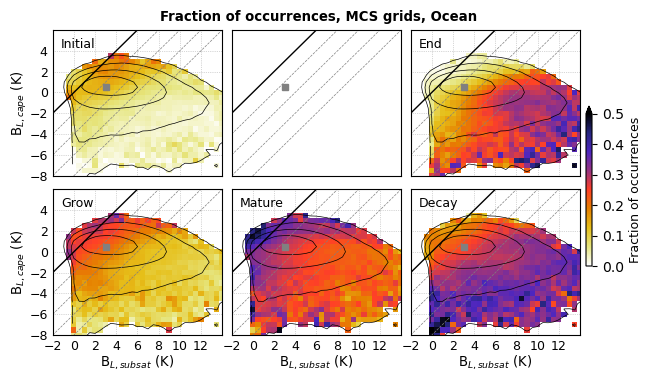

In [38]:
samples_3degmean = samples_all_ocean.sel(area_type='mcs').sum('duration_type')
dbl = 0.5
samples_3degmean = samples_3degmean.interp(bins_cape=np.arange(bins_cape[0],bins_cape[-1]+dbl,dbl),
                                           bins_subsat=np.arange(bins_subsat[0],bins_subsat[-1]+dbl,dbl))

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(6,4))

for p,(ax,phase,label) in enumerate(zip([ax1,ax3,ax4,ax5,ax6]
                                        ,['Initial','End','Grow','Mature','Decay']
                                        ,['(a)','(b)','(c)','(d)','(e)'])):
    
    samples_sub = samples_3degmean.sel(phase=phase)
    samples_allphases = samples_3degmean.sel(phase=['Initial','End','Grow','Mature','Decay']).sum('phase')

    fract_phase = samples_sub/samples_allphases
    tmp = samples_3degmean.sum('phase')
    fract_phase = fract_phase.where(samples_allphases >= 100) # samples greater than 100
    
    cp = ax.pcolormesh(fract_phase.bins_subsat, fract_phase.bins_cape, fract_phase, vmin=0, vmax=0.5, 
                       cmap='CMRmap_r', zorder=2)
    cp.cmap.set_over('k')
    
    if phase == 'End':
        cbaxes = fig.add_axes([0.985, 0.3, 0.01, 0.4])              
        cbar = plt.colorbar(cp, cax=cbaxes, shrink=0.7, extend='max')
        cbar.set_label('Fraction of occurrences',fontsize=9)
    
    # add contour 
    ax.contour(samples_allphases.bins_subsat, samples_allphases.bins_cape, np.log10(samples_allphases), 
               colors=['k'], levels=[2,3,4,5,6], linewidths=0.5)
    
    # add buoyancy reference 
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
    #ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+2, color='grey', ls='--',lw=0.5)
    #ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+4, color='grey', ls='--',lw=0.5)
    #ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+6, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-4, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-6, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-8, color='grey', ls='--',lw=0.5)
    
    # add cape-subsat mode of all phases
    (idx,idy) = unravel_index(samples_allphases.argmax(), samples_allphases.shape)
    cape_mode = samples_allphases.bins_cape[idx]
    subsat_mode = samples_allphases.bins_subsat[idy] 
    ax.plot(subsat_mode, cape_mode, 's', ms=4, color='grey')
    
    ## configuration of tick, labels
    ax.text(-1.2,4.3,'{}'.format(phase),fontsize=9,color='k')
    ax.grid(ls=':', lw=0.5, zorder=1)
    ax.set_xticks([-2,0,2,4,6,8,10,12])
    ax.set_yticks([-8,-6,-4,-2,0,2,4])
    ax.tick_params(labelsize=9)
    ax.tick_params('both', length=0, width=1, which='major')
    
    # set x-y domain 
    ax.set_ylim([-8,6])
    ax.set_xlim([-2,14])   

ax2.tick_params('both', length=0, width=1, which='major')
    
ax1.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax5.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax6.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])

track_num = int(samples_all_ocean.sel(area_type='amean',phase='CCS').sum().values)
plt.suptitle('Fraction of occurrences, MCS grids, Ocean', x=0.54, y=0.94, fontsize=9.5, fontweight='bold')
plt.tight_layout(h_pad=0.4,w_pad=0.02)

#====== schematic part for axis 2 =======
# add buoyancy reference 
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2, color='grey', ls='--',lw=0.5)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-4, color='grey', ls='--',lw=0.5)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-6, color='grey', ls='--',lw=0.5)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-8, color='grey', ls='--',lw=0.5)

(idx,idy) = unravel_index(samples_allphases.argmax(), samples_allphases.shape)
cape_mode = samples_allphases.bins_cape[idx]
subsat_mode = samples_allphases.bins_subsat[idy] 
ax2.plot(subsat_mode, cape_mode, 's', ms=4, color='grey')

ax2.set_ylim([-8,6])
ax2.set_xlim([-2,14])
plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/MCSgridsBL_fraction_occurrence.ocean.rotate.pdf',
       bbox_inches='tight',transparent=False)

#### over land

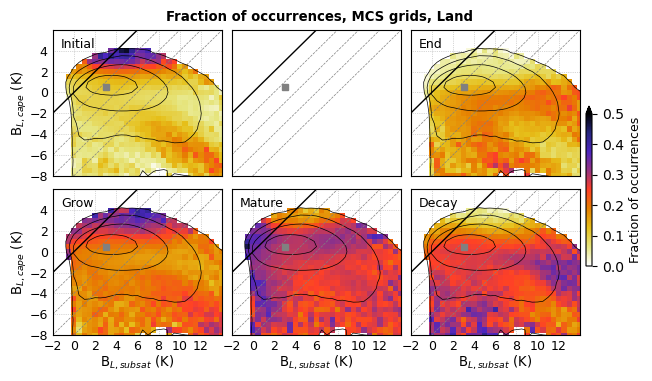

In [39]:
samples_3degmean = samples_all_land.sel(area_type='mcs').sum('duration_type')
dbl = 0.5
samples_3degmean = samples_3degmean.interp(bins_cape=np.arange(bins_cape[0],bins_cape[-1]+dbl,dbl),
                                           bins_subsat=np.arange(bins_subsat[0],bins_subsat[-1]+dbl,dbl))

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(6,4))

for p,(ax,phase,label) in enumerate(zip([ax1,ax3,ax4,ax5,ax6]
                                        ,['Initial','End','Grow','Mature','Decay']
                                        ,['(a)','(b)','(c)','(d)','(e)'])):
    
    samples_sub = samples_3degmean.sel(phase=phase)
    samples_allphases = samples_3degmean.sel(phase=['Initial','End','Grow','Mature','Decay']).sum('phase')

    fract_phase = samples_sub/samples_allphases
    tmp = samples_3degmean.sum('phase')
    fract_phase = fract_phase.where(samples_allphases >= 100) # samples greater than 100
    
    cp = ax.pcolormesh(fract_phase.bins_subsat, fract_phase.bins_cape, fract_phase, vmin=0, vmax=0.5, 
                       cmap='CMRmap_r', zorder=2)
    cp.cmap.set_over('k')
    
    if phase == 'End':
        cbaxes = fig.add_axes([0.985, 0.3, 0.01, 0.4])              
        cbar = plt.colorbar(cp, cax=cbaxes, shrink=0.7, extend='max')
        cbar.set_label('Fraction of occurrences',fontsize=9)
    
    # add contour 
    ax.contour(samples_allphases.bins_subsat, samples_allphases.bins_cape, np.log10(samples_allphases), 
               colors=['k'], levels=[2,3,4,5,6], linewidths=0.5)
    
    # add buoyancy reference 
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
    #ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+2, color='grey', ls='--',lw=0.5)
    #ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+4, color='grey', ls='--',lw=0.5)
    #ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+6, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-4, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-6, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-8, color='grey', ls='--',lw=0.5)
    
    # add cape-subsat mode of all phases
    (idx,idy) = unravel_index(samples_allphases.argmax(), samples_allphases.shape)
    cape_mode = samples_allphases.bins_cape[idx]
    subsat_mode = samples_allphases.bins_subsat[idy] 
    ax.plot(subsat_mode, cape_mode, 's', ms=4, color='grey')
    
    ## configuration of tick, labels
    ax.text(-1.2,4.3,'{}'.format(phase),fontsize=9,color='k')
    ax.grid(ls=':', lw=0.5, zorder=1)
    ax.set_xticks([-2,0,2,4,6,8,10,12])
    ax.set_yticks([-8,-6,-4,-2,0,2,4])
    ax.tick_params(labelsize=9)
    ax.tick_params('both', length=0, width=1, which='major')
    
    # set x-y domain 
    ax.set_ylim([-8,6])
    ax.set_xlim([-2,14])   

ax2.tick_params('both', length=0, width=1, which='major')
    
ax1.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax5.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax6.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])

track_num = int(samples_all_ocean.sel(area_type='amean',phase='CCS').sum().values)
plt.suptitle('Fraction of occurrences, MCS grids, Land', x=0.54, y=0.94, fontsize=9.5, fontweight='bold')
plt.tight_layout(h_pad=0.4,w_pad=0.02)

#====== schematic part for axis 2 =======
# add buoyancy reference 
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2, color='grey', ls='--',lw=0.5)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-4, color='grey', ls='--',lw=0.5)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-6, color='grey', ls='--',lw=0.5)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-8, color='grey', ls='--',lw=0.5)

(idx,idy) = unravel_index(samples_allphases.argmax(), samples_allphases.shape)
cape_mode = samples_allphases.bins_cape[idx]
subsat_mode = samples_allphases.bins_subsat[idy] 
ax2.plot(subsat_mode, cape_mode, 's', ms=4, color='grey')

ax2.set_ylim([-8,6])
ax2.set_xlim([-2,14])
plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/MCSgridsBL_fraction_occurrence.land.rotate.pdf',
       bbox_inches='tight',transparent=False)

#### Seperating by durationg types
- whether the excursion is wider for long-lived systems

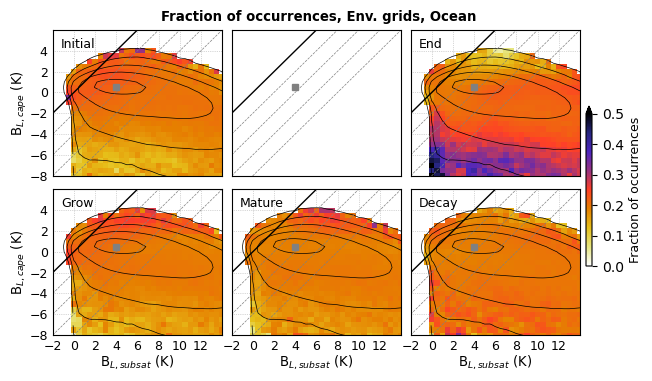

In [44]:
samples_3degmean = samples_all_ocean.sel(area_type='env').sum('duration_type')
dbl = 0.5
samples_3degmean = samples_3degmean.interp(bins_cape=np.arange(bins_cape[0],bins_cape[-1]+dbl,dbl),
                                           bins_subsat=np.arange(bins_subsat[0],bins_subsat[-1]+dbl,dbl))

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(6,4))

for p,(ax,phase,label) in enumerate(zip([ax1,ax3,ax4,ax5,ax6]
                                        ,['Initial','End','Grow','Mature','Decay']
                                        ,['(a)','(b)','(c)','(d)','(e)'])):
    
    samples_sub = samples_3degmean.sel(phase=phase)
    samples_allphases = samples_3degmean.sel(phase=['Initial','End','Grow','Mature','Decay']).sum('phase')

    fract_phase = samples_sub/samples_allphases
    tmp = samples_3degmean.sum('phase')
    fract_phase = fract_phase.where(samples_allphases >= 100) # samples greater than 100
    
    cp = ax.pcolormesh(fract_phase.bins_subsat, fract_phase.bins_cape, fract_phase, vmin=0, vmax=0.5, 
                       cmap='CMRmap_r', zorder=2)
    cp.cmap.set_over('k')
    
    if phase == 'End':
        cbaxes = fig.add_axes([0.985, 0.3, 0.01, 0.4])              
        cbar = plt.colorbar(cp, cax=cbaxes, shrink=0.7, extend='max')
        cbar.set_label('Fraction of occurrences',fontsize=9)
    
    # add contour 
    ax.contour(samples_allphases.bins_subsat, samples_allphases.bins_cape, np.log10(samples_allphases), 
               colors=['k'], levels=[2,3,4,5,6], linewidths=0.5)
    
    # add buoyancy reference 
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
    #ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+2, color='grey', ls='--',lw=0.5)
    #ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+4, color='grey', ls='--',lw=0.5)
    #ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+6, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-4, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-6, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-8, color='grey', ls='--',lw=0.5)
    
    # add cape-subsat mode of all phases
    (idx,idy) = unravel_index(samples_allphases.argmax(), samples_allphases.shape)
    cape_mode = samples_allphases.bins_cape[idx]
    subsat_mode = samples_allphases.bins_subsat[idy] 
    ax.plot(subsat_mode, cape_mode, 's', ms=4, color='grey')
    
    ## configuration of tick, labels
    ax.text(-1.2,4.3,'{}'.format(phase),fontsize=9,color='k')
    ax.grid(ls=':', lw=0.5, zorder=1)
    ax.set_xticks([-2,0,2,4,6,8,10,12])
    ax.set_yticks([-8,-6,-4,-2,0,2,4])
    ax.tick_params(labelsize=9)
    ax.tick_params('both', length=0, width=1, which='major')
    
    # set x-y domain 
    ax.set_ylim([-8,6])
    ax.set_xlim([-2,14])   

ax2.tick_params('both', length=0, width=1, which='major')
    
ax1.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax5.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax6.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])

track_num = int(samples_all_ocean.sel(area_type='amean',phase='CCS').sum().values)
plt.suptitle('Fraction of occurrences, Env. grids, Ocean', x=0.54, y=0.94, fontsize=9.5, fontweight='bold')
plt.tight_layout(h_pad=0.4,w_pad=0.02)

#====== schematic part for axis 2 =======
# add buoyancy reference 
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2, color='grey', ls='--',lw=0.5)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-4, color='grey', ls='--',lw=0.5)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-6, color='grey', ls='--',lw=0.5)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-8, color='grey', ls='--',lw=0.5)

(idx,idy) = unravel_index(samples_allphases.argmax(), samples_allphases.shape)
cape_mode = samples_allphases.bins_cape[idx]
subsat_mode = samples_allphases.bins_subsat[idy] 
ax2.plot(subsat_mode, cape_mode, 's', ms=4, color='grey')

ax2.set_ylim([-8,6])
ax2.set_xlim([-2,14])
plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/EnvgridsBL_fraction_occurrence.ocean.rotate.pdf',
       bbox_inches='tight',transparent=False)

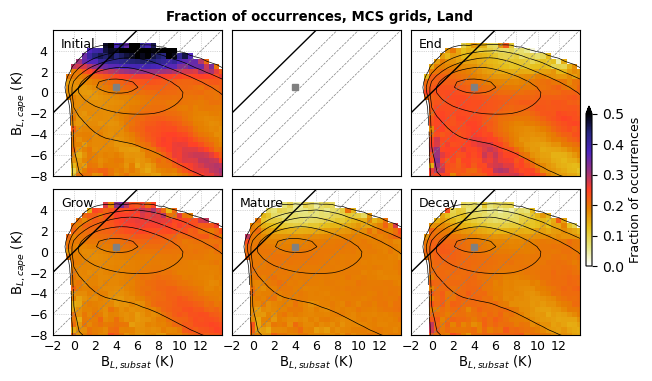

In [45]:
samples_3degmean = samples_all_land.sel(area_type='env').sum('duration_type')
dbl = 0.5
samples_3degmean = samples_3degmean.interp(bins_cape=np.arange(bins_cape[0],bins_cape[-1]+dbl,dbl),
                                           bins_subsat=np.arange(bins_subsat[0],bins_subsat[-1]+dbl,dbl))

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(6,4))

for p,(ax,phase,label) in enumerate(zip([ax1,ax3,ax4,ax5,ax6]
                                        ,['Initial','End','Grow','Mature','Decay']
                                        ,['(a)','(b)','(c)','(d)','(e)'])):
    
    samples_sub = samples_3degmean.sel(phase=phase)
    samples_allphases = samples_3degmean.sel(phase=['Initial','End','Grow','Mature','Decay']).sum('phase')

    fract_phase = samples_sub/samples_allphases
    tmp = samples_3degmean.sum('phase')
    fract_phase = fract_phase.where(samples_allphases >= 100) # samples greater than 100
    
    cp = ax.pcolormesh(fract_phase.bins_subsat, fract_phase.bins_cape, fract_phase, vmin=0, vmax=0.5, 
                       cmap='CMRmap_r', zorder=2)
    cp.cmap.set_over('k')
    
    if phase == 'End':
        cbaxes = fig.add_axes([0.985, 0.3, 0.01, 0.4])              
        cbar = plt.colorbar(cp, cax=cbaxes, shrink=0.7, extend='max')
        cbar.set_label('Fraction of occurrences',fontsize=9)
    
    # add contour 
    ax.contour(samples_allphases.bins_subsat, samples_allphases.bins_cape, np.log10(samples_allphases), 
               colors=['k'], levels=[2,3,4,5,6], linewidths=0.5)
    
    # add buoyancy reference 
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
    #ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+2, color='grey', ls='--',lw=0.5)
    #ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+4, color='grey', ls='--',lw=0.5)
    #ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+6, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-4, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-6, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-8, color='grey', ls='--',lw=0.5)
    
    # add cape-subsat mode of all phases
    (idx,idy) = unravel_index(samples_allphases.argmax(), samples_allphases.shape)
    cape_mode = samples_allphases.bins_cape[idx]
    subsat_mode = samples_allphases.bins_subsat[idy] 
    ax.plot(subsat_mode, cape_mode, 's', ms=4, color='grey')
    
    ## configuration of tick, labels
    ax.text(-1.2,4.3,'{}'.format(phase),fontsize=9,color='k')
    ax.grid(ls=':', lw=0.5, zorder=1)
    ax.set_xticks([-2,0,2,4,6,8,10,12])
    ax.set_yticks([-8,-6,-4,-2,0,2,4])
    ax.tick_params(labelsize=9)
    ax.tick_params('both', length=0, width=1, which='major')
    
    # set x-y domain 
    ax.set_ylim([-8,6])
    ax.set_xlim([-2,14])   

ax2.tick_params('both', length=0, width=1, which='major')
    
ax1.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax5.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax6.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])

track_num = int(samples_all_ocean.sel(area_type='amean',phase='CCS').sum().values)
plt.suptitle('Fraction of occurrences, MCS grids, Land', x=0.54, y=0.94, fontsize=9.5, fontweight='bold')
plt.tight_layout(h_pad=0.4,w_pad=0.02)

#====== schematic part for axis 2 =======
# add buoyancy reference 
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2, color='grey', ls='--',lw=0.5)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-4, color='grey', ls='--',lw=0.5)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-6, color='grey', ls='--',lw=0.5)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-8, color='grey', ls='--',lw=0.5)

(idx,idy) = unravel_index(samples_allphases.argmax(), samples_allphases.shape)
cape_mode = samples_allphases.bins_cape[idx]
subsat_mode = samples_allphases.bins_subsat[idy] 
ax2.plot(subsat_mode, cape_mode, 's', ms=4, color='grey')

ax2.set_ylim([-8,6])
ax2.set_xlim([-2,14])
plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/EnvgridsBL_fraction_occurrence.land.rotate.pdf',
       bbox_inches='tight',transparent=False)